In [1]:
import torch
import numpy as np
# import time
# import math
import matplotlib.pyplot as plt
import torch.nn as nn
# import torch.nn.functional as F
import pandas as pd
import torch.utils.data as data
from sklearn.metrics import roc_auc_score, RocCurveDisplay, roc_curve


In [2]:
if torch.cuda.is_available(): 
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

In [6]:
def prepare_data(df, std=None, mean=None):
  numerical_data = df[["YearBuilt","Size(sqf)","Floor","N_Parkinglot(Ground)","N_Parkinglot(Basement)","N_manager","N_elevators","N_FacilitiesInApt","N_FacilitiesNearBy(Total)","N_SchoolNearBy(Total)"]]
  numerical_data = df[[YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)]]

  time_to_bus_stop = pd.Series.to_frame(df["TimeToBusStop"].str.replace('-','~').str.split('~',1,expand=True)[1].str.slice(stop=-3)).rename(columns={1: 'TimeToBusStop'})
  time_to_subway = pd.Series.to_frame(df["TimeToSubway"].str.replace('-','~').str.split('~',1,expand=True)[1].str.slice(stop=-3)).rename(columns={1: 'TimeToSubway'})
  time_to_subway.fillna(2*np.nanmax(time_to_subway.astype("float").values),inplace=True)
  subway = pd.Series.to_frame(df.TimeToSubway != "no_bus_stop_nearby").rename({"TimeToSubway":"Subway"})
  numerical_data =  pd.concat([numerical_data,time_to_bus_stop], axis=1).astype(float)
  if std is None or mean is None:
    std=np.std(numerical_data)
    mean=np.mean(numerical_data)
  numerical_data -= mean
  numerical_data /= std
  boolean_data = pd.concat([df["HeatingType"] == "central_heating",df["AptManageType"] == "self_management"], axis=1)
  categorical_data = pd.get_dummies(df[["SubwayStation","TimeToSubway"]])
  df_data =  pd.concat([numerical_data,boolean_data,categorical_data], axis=1)
  df_data = torch.from_numpy(df_data.astype(float).values)
  if "SalePrice" in df:
    targets = torch.from_numpy(df["SalePrice"].astype(float).values)  > 300000
    return data.TensorDataset(df_data,targets), std, mean
  else:
    return data.TensorDataset(df_data), std, mean

In [7]:
df = pd.read_csv('train_data.csv')
df_train=df.sample(frac=0.8,random_state=200) #random state is a seed value
df_test=df.drop(df_train.index)
df_eval = pd.read_csv('test_data.csv')
train_dataset, std, mean = prepare_data(df_train)
test_dataset = prepare_data(df_test, std, mean)[0]
eval_dataset = prepare_data(df_eval, std, mean)[0]
train_data_loader = data.DataLoader(train_dataset, batch_size=512, shuffle=True, drop_last=True)
test_data_loader = data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True, drop_last=False)
eval_data_loader = data.DataLoader(eval_dataset, batch_size=len(eval_dataset), shuffle=False, drop_last=False)

NameError: name 'YearBuilt' is not defined

Przygotowanie sieci

In [12]:
class SimpleClassifier(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_hidden2, num_outputs):
        # Initialize the modules we need to build the network
        super().__init__()
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear3 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear3(x)
        return x

Utworzenie sieci i przygotowanie do jej nauki

In [13]:
model = SimpleClassifier(num_inputs=len(train_dataset[0][0]), num_hidden=26, num_hidden2=26, num_outputs=1)

#optimizer = torch.optim.SGD(model.parameters(), lr = 0.00001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.00001)
targets = torch.from_numpy((df_train.SalePrice>300000).astype(float).values)
loss_module = nn.BCEWithLogitsLoss(pos_weight=(len(targets)-sum(targets))/sum(targets))
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
model.train() 
loss_progress = []

Epoch: 0, loss: 0.949
Epoch: 1, loss: 0.705
Epoch: 2, loss: 0.644
Epoch: 3, loss: 0.596
Epoch: 4, loss: 0.535
Epoch: 5, loss: 0.481
Epoch: 6, loss: 0.433
Epoch: 7, loss: 0.444
Epoch: 8, loss: 0.343
Epoch: 9, loss: 0.389
Epoch: 10, loss: 0.346
Epoch: 11, loss: 0.291
Epoch: 12, loss: 0.255
Epoch: 13, loss: 0.216
Epoch: 14, loss: 0.308
Epoch: 15, loss: 0.262
Epoch: 16, loss: 0.235
Epoch: 17, loss: 0.278
Epoch: 18, loss: 0.239
Epoch: 19, loss: 0.187
Epoch: 20, loss: 0.244
Epoch: 21, loss: 0.22
Epoch: 22, loss: 0.261
Epoch: 23, loss: 0.209
Epoch: 24, loss: 0.255
Epoch: 25, loss: 0.202
Epoch: 26, loss: 0.214
Epoch: 27, loss: 0.201
Epoch: 28, loss: 0.166
Epoch: 29, loss: 0.263
Epoch: 30, loss: 0.257
Epoch: 31, loss: 0.198
Epoch: 32, loss: 0.2
Epoch: 33, loss: 0.217
Epoch: 34, loss: 0.199
Epoch: 35, loss: 0.223
Epoch: 36, loss: 0.221
Epoch: 37, loss: 0.197
Epoch: 38, loss: 0.183
Epoch: 39, loss: 0.206
Epoch: 40, loss: 0.218
Epoch: 41, loss: 0.191
Epoch: 42, loss: 0.229
Epoch: 43, loss: 0.225
E

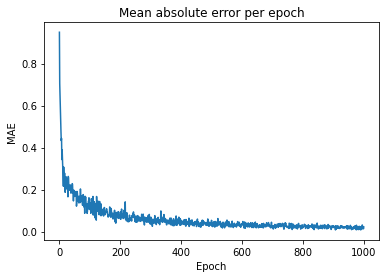

In [14]:
for epoch in range(1000):
    for data_inputs, data_labels in train_data_loader:

        data_inputs = data_inputs.to(device)
        data_labels = data_labels.to(device)

        preds = model(data_inputs.float())
        preds = preds.squeeze(dim=1) 
        
        loss = loss_module(preds, data_labels.float())
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()

    print(f"Epoch: {epoch}, loss: {loss.item():.3}")
    loss_progress.append(loss.item())
plt.plot(loss_progress)
plt.title('Mean absolute error per epoch')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.show()

Przygotowanie do ewaluacji

In [15]:
model.eval()

SimpleClassifier(
  (linear1): Linear(in_features=39, out_features=26, bias=True)
  (act_fn): Sigmoid()
  (linear3): Linear(in_features=26, out_features=1, bias=True)
)

Ewaluacja